## Import packages

In [1]:
import os
from collections import OrderedDict as ordict
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns                                # $:~ conda install seaborn
import scipy.stats as stats
import scipy.optimize as opt

%matplotlib inline

## Style settings

In [2]:
sns.set_style('white')
sns.set_context('paper')
sns.set_palette(sns.dark_palette('blue'))

matplotlib.rcParams['xtick.labelsize'] = 30 # 30 = 14 (abstract = poster)
matplotlib.rcParams['ytick.labelsize'] = 30
matplotlib.rcParams['axes.labelsize'] = 35 # 35 = 16
matplotlib.rcParams['legend.fontsize'] = 30
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.default'] = 'rm'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'

greens = sns.cubehelix_palette(n_colors=5, start=2.0, rot=.2, gamma=1, hue=.8, light=.8, dark=.15)
reds = sns.cubehelix_palette(n_colors=3, start=0.8, rot=.1, gamma=.7, hue=2, light=.7, dark=.15)

colorlist = [greens, reds]
sns.set_palette(greens)

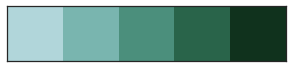

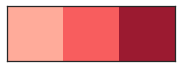

In [3]:
sns.palplot(greens)
sns.palplot(reds)

In [4]:
print('red', [int(256*r) for r in reds[1]])
print('green', [int(256*g) for g in greens[2]])

red [249, 93, 94]
green [75, 144, 125]


## Load Data

In [5]:
# DO NOT put data into github folders!

gdpath = os.path.expanduser('~/Google Drive/Bas Zahy Gianni - Games')
figdir = os.path.join(gdpath, 'Presentations/201702 Cosyne 2017/Figures')# 'Manuscripts/Cosyne2017Abstract/Figures') # for abstract

params_lrn = pd.read_csv(os.path.join(gdpath, 'Analysis/3_lrn/params_learn_final.csv'))
params_tai = pd.read_csv(os.path.join(gdpath, 'Analysis/5_tai/params_tai_final.csv'))

In [6]:
params_tai['condition'] = params_tai['condition'].map({0: 5, 1: 10, 2:20})
params_tai['rt'] = params_tai['rt']/1000
params_lrn['rt'] = params_lrn['rt']/1000

mean_correction_fields = [
    'elo', 'tree_size', 'attention', 'rt', 'lapse', 'act_scale', 'prune_thresh', 
    'value_quality', 'weight_center', 'weight_2conn', 'weight_2unc', 'weight_3', 'weight_4'
]

mean_correction_labels = ['mc ' + i for i in mean_correction_fields]

for i, p in enumerate([params_tai, params_lrn]):
    for val in mean_correction_fields:
        if val in p.columns:
            nv = 'mc ' + val
            mean_correction_labels.append(nv)
            mean_elos = p.pivot_table(index='subject', values=val) # note to self: rename this to not be confusing!
            for i in p.subject.unique():
                p.loc[p.subject==i, nv] = p.loc[p.subject==i, val] - mean_elos[i]
            p[nv] = p[nv].fillna(method='ffill')
            
pl = params_lrn.groupby(['subject', 'session']).mean().reset_index()
pt = params_tai.groupby(['subject', 'condition']).mean().reset_index()

In [7]:
def get_corr_table(df, regressor_label):
    S = pd.DataFrame(index=mean_correction_labels, columns=['r', 'p'])
    for m in S.index:
        res = stats.linregress(df[regressor_label], df[m])
        S.loc[m, ['r', 'p']] = res.rvalue, res.pvalue
        
    return S

In [8]:
tai_corrs = dict()
for s in ['condition', 'mc rt', 'mc elo']:
    S = get_corr_table(params_tai, s)
    S.to_csv(os.path.join(gdpath, 'Analysis/5_tai/correlations/{}.csv'.format(s)))
    tai_corrs[s] = S

lrn_corrs = dict()
for s in ['session', 'mc elo', 'mc rt']:
    S = get_corr_table(params_lrn, s)
    S.to_csv(os.path.join(gdpath, 'Analysis/3_lrn/correlations/{}.csv'.format(s)))
    lrn_corrs[s] = S

# Final plots

In [9]:
errkws = {'linewidth': 3.8}
lineplotkws = {'linewidth': .5, 'alpha': .4, 'color': 'grey', 'label': 'none'}
scatterkws = {'linestyle': 'none', 'marker': 'o', 'markersize': 9}

def format_regression_text(res):
    if res.pvalue < .001:
        pval = .001
    elif res.pvalue < .01:
        pval = .01
    elif res.pvalue < .05:
        pval = .05
    else:
        pval = res.pvalue

    if res.pvalue <= .001:
        textstring = r'$\it{{p}}$ < {:.3f}, $\it{{r}}$ = {:.2f}'
    elif res.pvalue < .05:
        textstring = r'$\it{{p}}$ < {:.2f}, $\it{{r}}$ = {:.2f}'
    else:
        textstring = r'$\it{{p}}$ = {:.2f}, $\it{{r}}$ = {:.2f}'

    textstring = textstring.format(pval, res.rvalue)

    return textstring

def curve_like_plot(param, experiment, ax=None, scatterkws=scatterkws, errkws=errkws, lineon=True, texton=False):
    if experiment == 'learning':
        split = 'session'
        colors = greens
        df = params_lrn
    elif experiment == 'timed':
        split = 'condition'
        colors = reds
        df = params_tai
            
    y = df.pivot_table(index=split, values=param, aggfunc=np.mean)
    yinterval = df.pivot_table(index=split, values=param, aggfunc=lambda x: stats.sem(x))
    
    if lineon:
        ax.plot(y.index, y.values, color='black')
    
    if texton:
        res = stats.linregress(df[split], df[param])
        textstring = format_regression_text(res)
        ax.text(0.04, 0.03, textstring, fontsize=29, transform=ax.transAxes)
        
    for ii, i in enumerate(df[split].unique()):
        ax.plot(i, y[i], color=colors[ii], **scatterkws)
        ax.errorbar(i, y[i], yinterval[i], color=colors[ii], **errkws)
        
    return None

def scatter_plot(param1, param2, experiment, 
                 ax=None, reduce=False, 
                 lineon=True, texton=False, textloc='bottom', printslope=False,
                 scatterkws=scatterkws):
    if experiment == 'learning':
        split = 'session'
        colors = greens
        df = pl if reduce else params_lrn
    elif experiment == 'timed':
        split = 'condition'
        colors = reds
        df = pt if reduce else params_tai
        
    if lineon:
        for ii, i in enumerate(df['subject'].unique()):
            p = df.loc[df['subject']==i]
            ax.plot(p[param1], p[param2], **lineplotkws)
    
    if texton:
        res = stats.linregress(df[param1], df[param2])
        if printslope:
            print(res.slope)
        textstring = format_regression_text(res)
        texty = .03 if textloc=='bottom' else .95
        ax.text(0.04, texty, textstring, fontsize=29, transform=ax.transAxes)
        
    for ii, i in enumerate(df[split].unique()):
        p = df.loc[df[split]==i]
        ax.plot(p[param1], p[param2], color=colors[ii], **scatterkws)
        
    return None

/Users/gianni/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


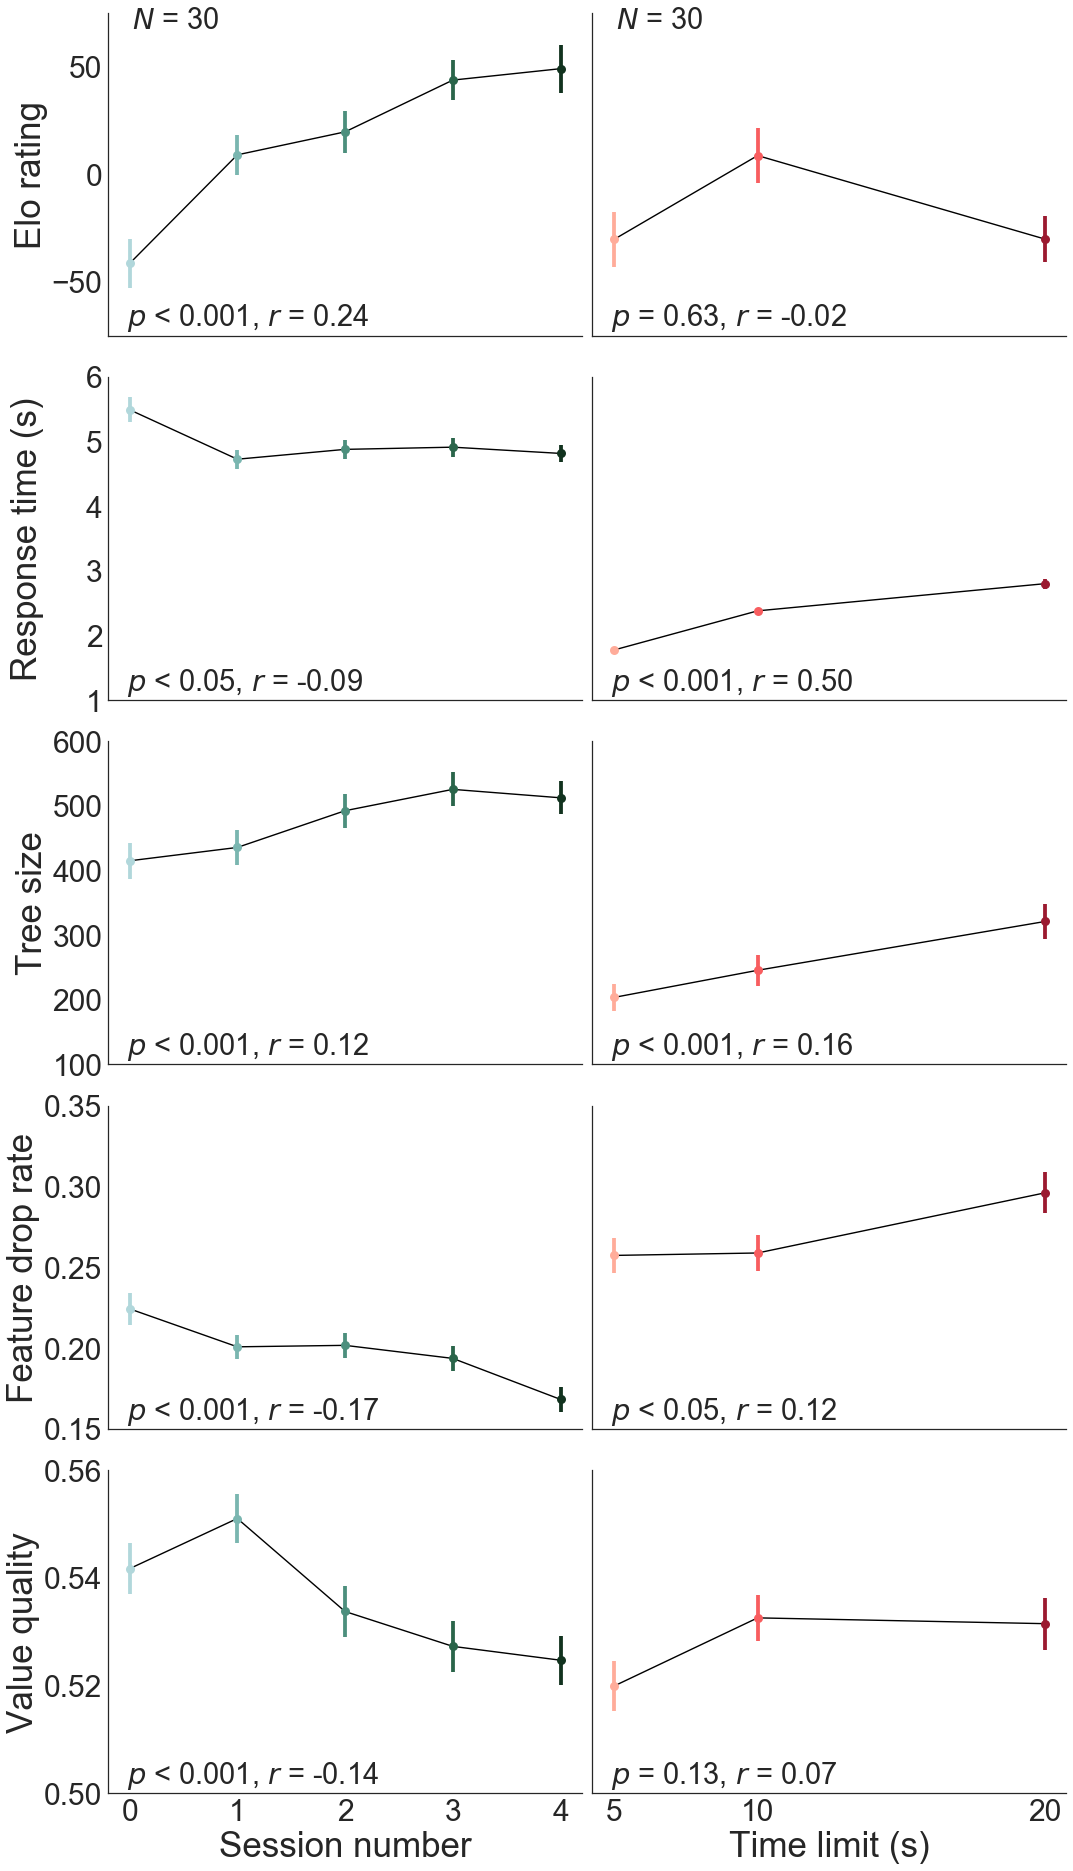

In [275]:
fig, axes = plt.subplots(5, 2, figsize=(15, 26))

for row, variable in enumerate(['elo', 'rt', 'tree_size', 'attention', 'value_quality']):
    ax = axes[row, 0]
    curve_like_plot(variable, 'learning', ax=ax, texton=True)
    
    ax = axes[row, 1]
    curve_like_plot(variable, 'timed', ax=ax, texton=True)

axes[0, 0].text(.05, .95, r"$\it{N}$ = 30", fontsize=29, transform=axes[0, 0].transAxes)
axes[0, 1].text(.05, .95, r"$\it{N}$ = 30", fontsize=29, transform=axes[0, 1].transAxes)


plt.setp(axes, xticks=[])
plt.setp(axes[:, 1], yticks=[])
plt.setp(axes[0, :], ylim=[-75, 75])
plt.setp(axes[0, 0], ylabel='Elo rating')
plt.setp(axes[1, :], ylim=[1, 6])
plt.setp(axes[1, 0], ylabel='Response time (s)\n')
plt.setp(axes[2, :], ylim=[100, 600])
plt.setp(axes[2, 0], ylabel='Tree size')
plt.setp(axes[3, :], ylim=[.15, .35])
plt.setp(axes[3, 0], ylabel='Feature drop rate')

plt.setp(axes[4, :], ylim=[.5, .56])
plt.setp(axes[4, 0], xticks=[0, 1, 2, 3, 4], xlabel='Session number', ylabel='Value quality')
plt.setp(axes[4, 1], xticks=[5, 10, 20], xlabel='Time limit (s)')
    
sns.despine()
plt.tight_layout()
fig.savefig(os.path.join(figdir, 'variables vs condition.png'))

/Users/gianni/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


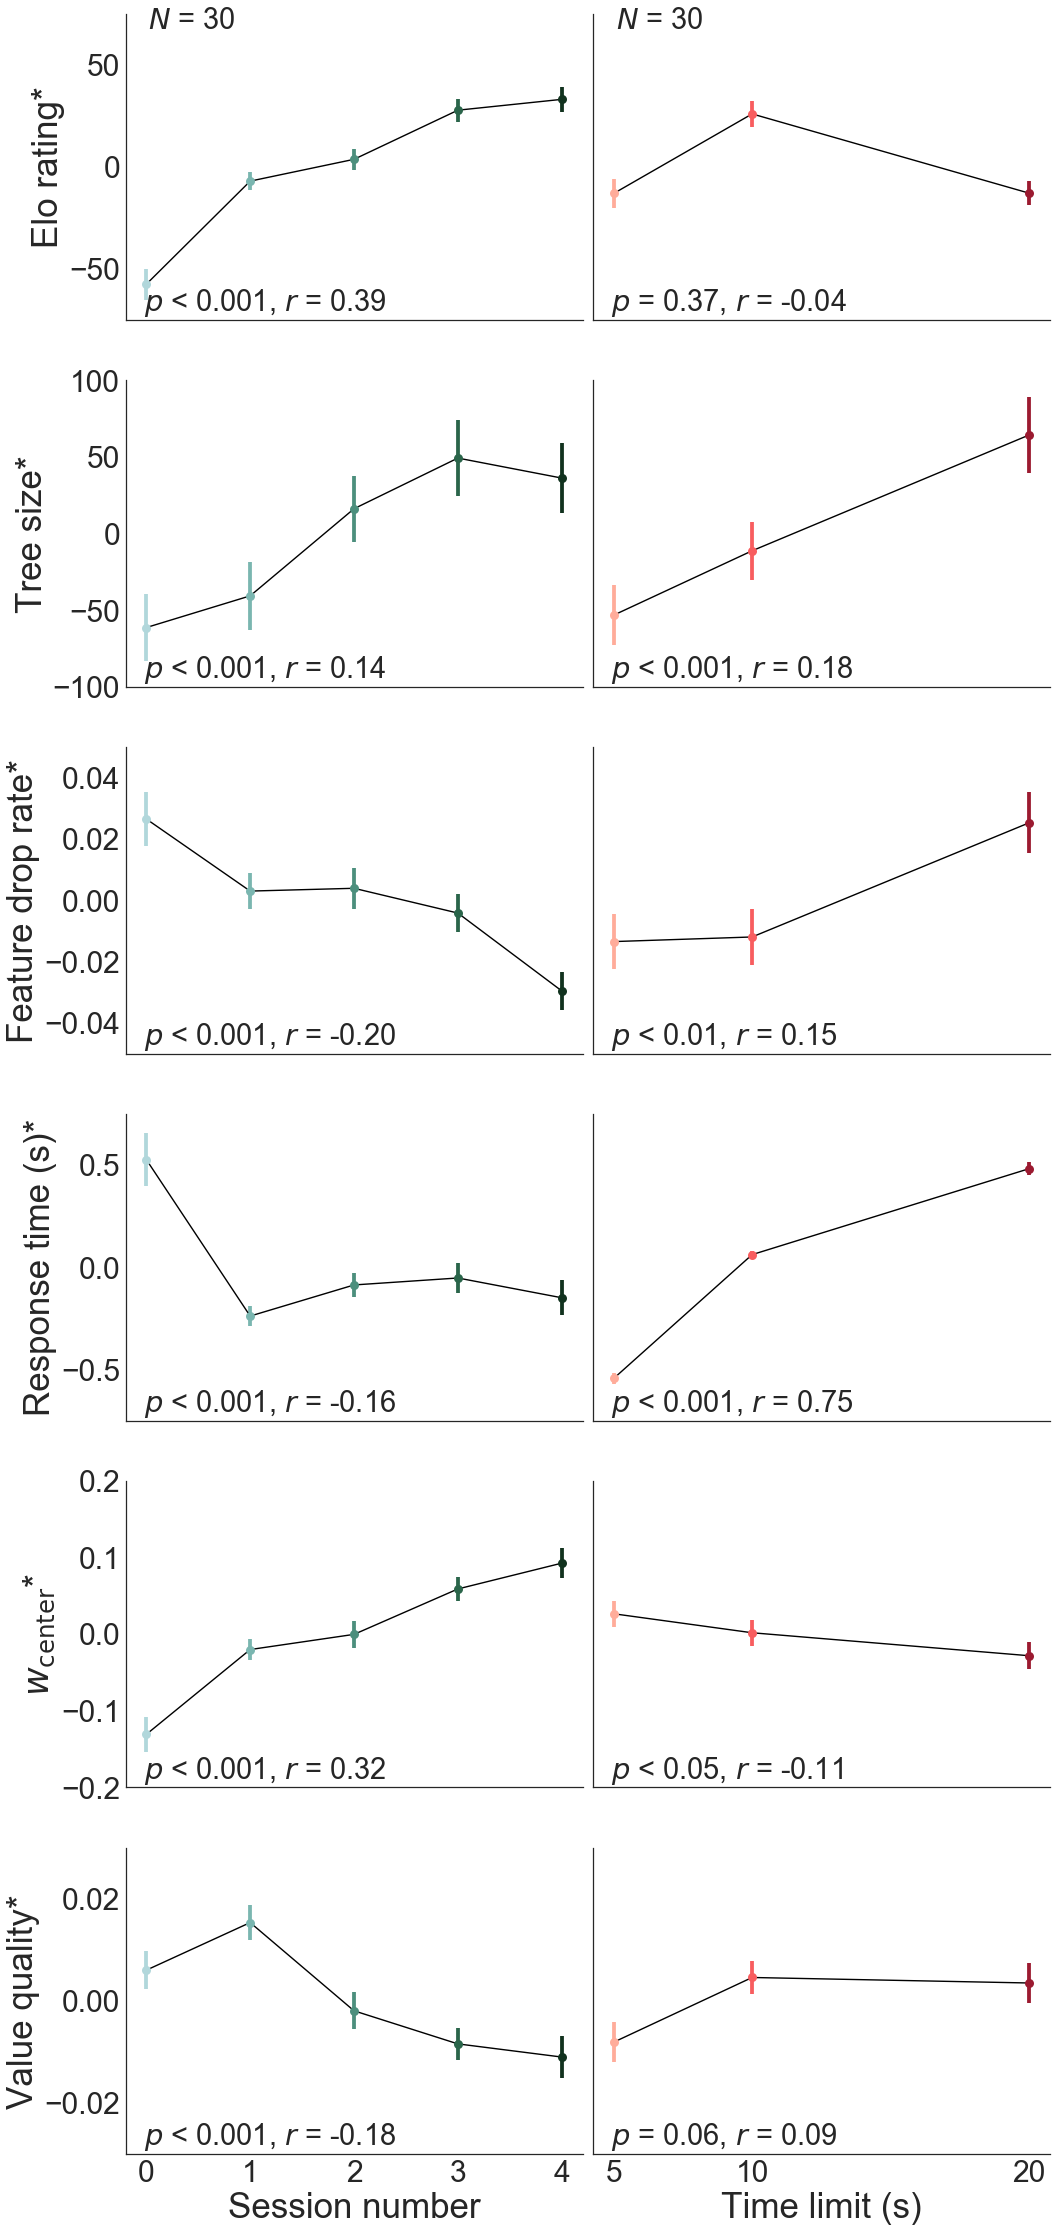

In [62]:
fig, axes = plt.subplots(6, 2, figsize=(15, 31))

for row, variable in enumerate(['elo', 'tree_size', 'attention', 'rt', 'weight_center', 'value_quality']):
    ax = axes[row, 0]
    curve_like_plot('mc ' + variable, 'learning', ax=ax, texton=True)
    
    ax = axes[row, 1]
    curve_like_plot('mc ' + variable, 'timed', ax=ax, texton=True)

axes[0, 0].text(.05, .95, r"$\it{N}$ = 30", fontsize=29, transform=axes[0, 0].transAxes)
axes[0, 1].text(.05, .95, r"$\it{N}$ = 30", fontsize=29, transform=axes[0, 1].transAxes)


plt.setp(axes, xticks=[])
plt.setp(axes[:, 1], yticks=[])

plt.setp(axes[0, :], ylim=[-75, 75])
plt.setp(axes[0, 0], ylabel='Elo rating*')

plt.setp(axes[1, :], ylim=[-100, 100])
plt.setp(axes[1, 0], ylabel='Tree size*')

plt.setp(axes[2, :], ylim=[-.05, .05])
plt.setp(axes[2, 0], ylabel='Feature drop rate*')

plt.setp(axes[3, :], ylim=[-.75, .75])
plt.setp(axes[3, 0], ylabel='Response time (s)*')

plt.setp(axes[4, :], ylim=[-.2, .2])
plt.setp(axes[4, 0], ylabel=r'$\it{w}_{\mathrm{center}}$*')

plt.setp(axes[5, :], ylim=[-.03, .03])
plt.setp(axes[5, 0], xticks=[0, 1, 2, 3, 4], xlabel='Session number', ylabel='Value quality*')
plt.setp(axes[5, 1], xticks=[5, 10, 20], xlabel='Time limit (s)')
    
sns.despine()
plt.tight_layout()
fig.savefig(os.path.join(figdir, 'mc variables vs condition.png'))

/Users/gianni/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


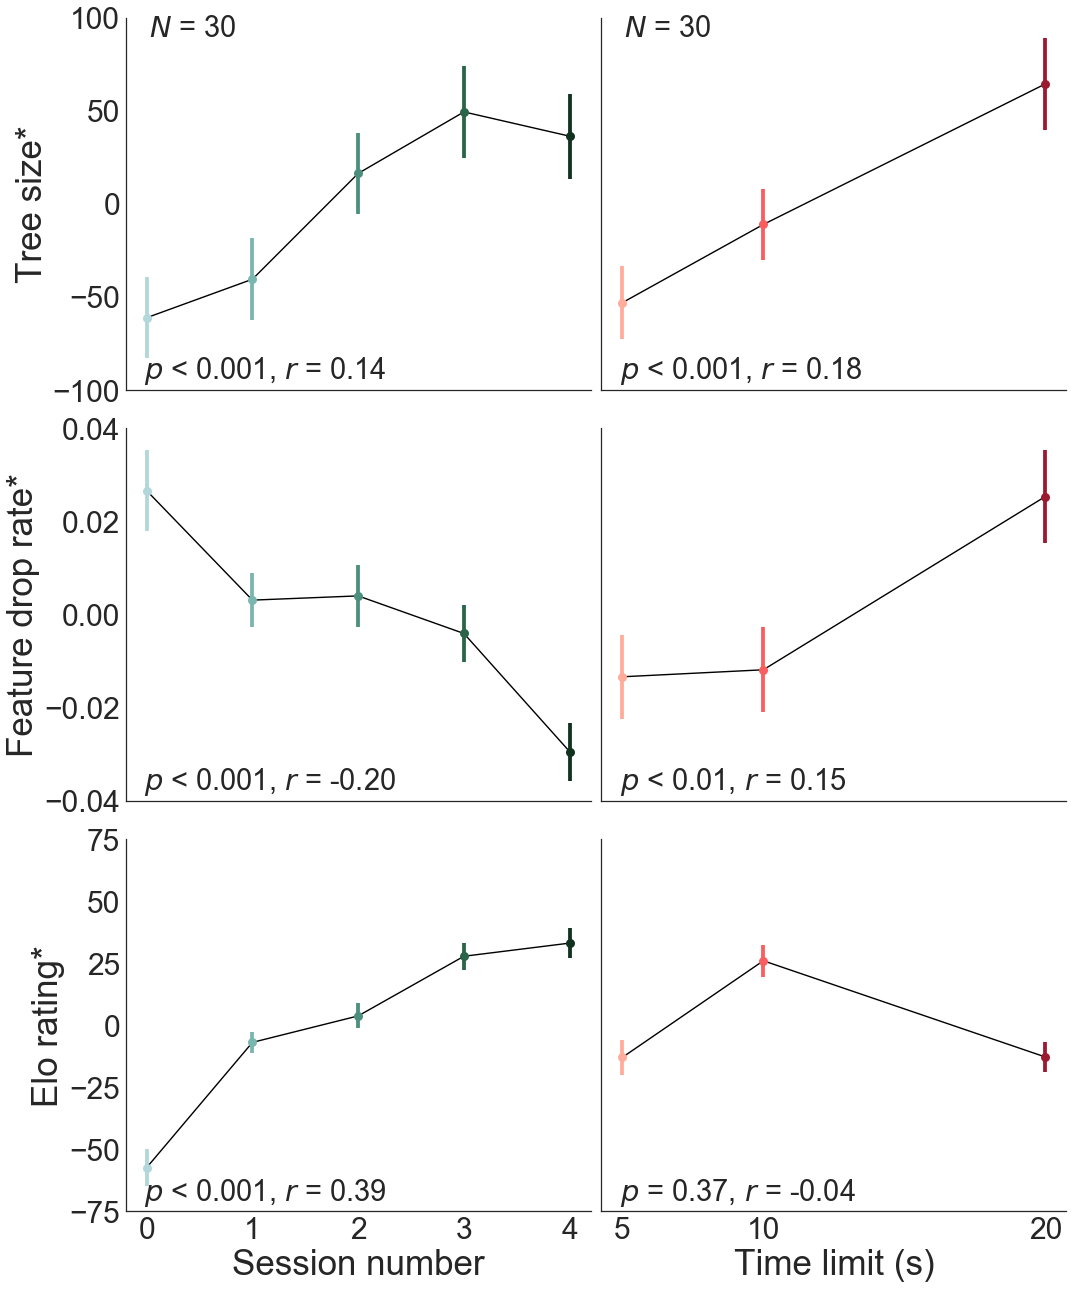

In [59]:
fig, axes = plt.subplots(3, 2, figsize=(15, 18))

for row, variable in enumerate(['tree_size', 'attention', 'elo']):
    ax = axes[row, 0]
    curve_like_plot('mc ' + variable, 'learning', ax=ax, texton=True)
    
    ax = axes[row, 1]
    curve_like_plot('mc ' + variable, 'timed', ax=ax, texton=True)

axes[0, 0].text(.05, .95, r"$\it{N}$ = 30", fontsize=29, transform=axes[0, 0].transAxes)
axes[0, 1].text(.05, .95, r"$\it{N}$ = 30", fontsize=29, transform=axes[0, 1].transAxes)


plt.setp(axes, xticks=[])
plt.setp(axes[:, 1], yticks=[])
plt.setp(axes[0, :], ylim=[-100, 100])
plt.setp(axes[0, 0], ylabel='Tree size*')
plt.setp(axes[1, :], ylim=[-.04, .04])
plt.setp(axes[1, 0], ylabel='Feature drop rate*')
plt.setp(axes[2, :], ylim=[-75, 75])
plt.setp(axes[2, 0], xticks=[0, 1, 2, 3, 4], xlabel='Session number', ylabel='Elo rating*')
plt.setp(axes[2, 1], xticks=[5, 10, 20], xlabel='Time limit (s)')
    
sns.despine()
plt.tight_layout()
fig.savefig(os.path.join(figdir, 'ts fd elo condition.png'))

/Users/gianni/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


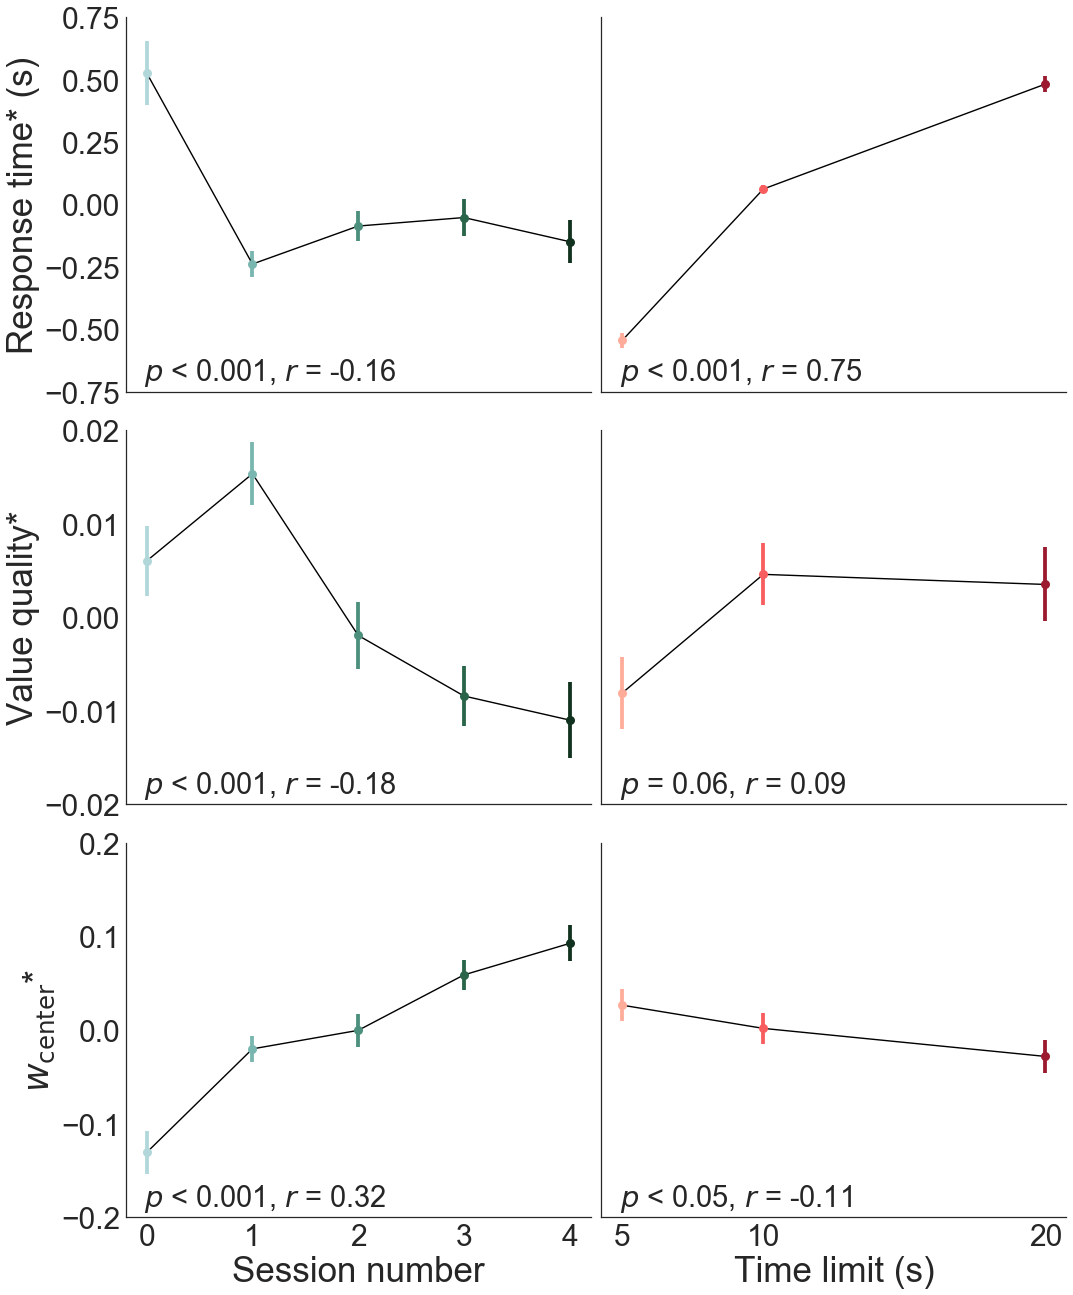

In [61]:
fig, axes = plt.subplots(3, 2, figsize=(15, 18), squeeze=False)

for row, variable in enumerate(['rt', 'value_quality', 'weight_center']):
    ax = axes[row, 0]
    curve_like_plot('mc ' + variable, 'learning', ax=ax, texton=True)
    
    ax = axes[row, 1]
    curve_like_plot('mc ' + variable, 'timed', ax=ax, texton=True)

plt.setp(axes, xticks=[])
plt.setp(axes[:, 1], yticks=[])

plt.setp(axes[0, :], ylim=[-.75, .75])
plt.setp(axes[0, 0], ylabel='Response time* (s)')
plt.setp(axes[1, :], ylim=[-.02, .02])
plt.setp(axes[1, 0], ylabel='Value quality*')
plt.setp(axes[2, :], ylim=[-.2, .2])
plt.setp(axes[2, 0], ylabel=r'$\it{w}_{\mathrm{center}}$*', xticks=[0, 1, 2, 3, 4], xlabel='Session number')
plt.setp(axes[2, 1], xticks=[5, 10, 20], xlabel='Time limit (s)')
    
sns.despine()
plt.tight_layout()
fig.savefig(os.path.join(figdir, 'mc vq w_c rt condition.png'))

/Users/gianni/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


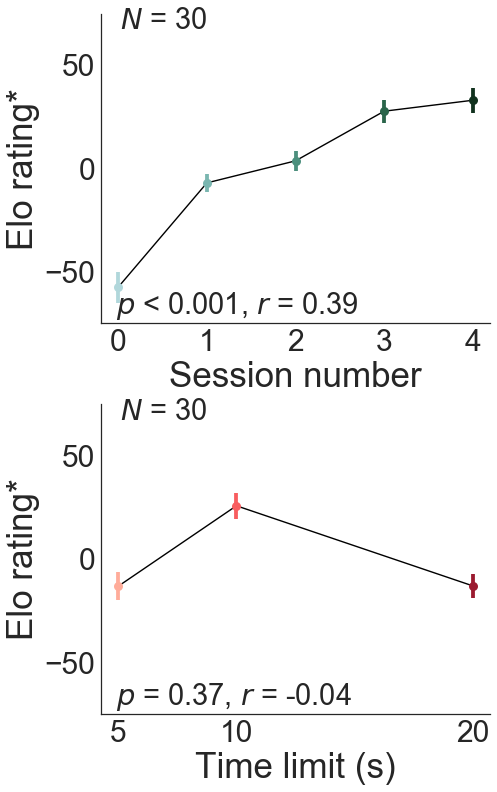

In [36]:
fig, axes = plt.subplots(2, 1, figsize=(7, 11), squeeze=False)

for row, variable in enumerate(['elo']):
    ax = axes[0, row]
    curve_like_plot('mc ' + variable, 'learning', ax=ax, texton=True)
    
    ax = axes[1, row]
    curve_like_plot('mc ' + variable, 'timed', ax=ax, texton=True)

axes[0, 0].text(.05, .95, r"$\it{N}$ = 30", fontsize=29, transform=axes[0, 0].transAxes)
axes[1, 0].text(.05, .95, r"$\it{N}$ = 30", fontsize=29, transform=axes[1, 0].transAxes)


plt.setp(axes, ylim=[-75, 75], ylabel='Elo rating*')
plt.setp(axes[0, 0], xlabel='Session number', xticks=[0, 1, 2, 3, 4])
plt.setp(axes[1, 0], xticks=[5, 10, 20], xlabel='Time limit (s)')
    
sns.despine()
plt.tight_layout()
fig.savefig(os.path.join(figdir, 'mc elo vs condition'))

/Users/gianni/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


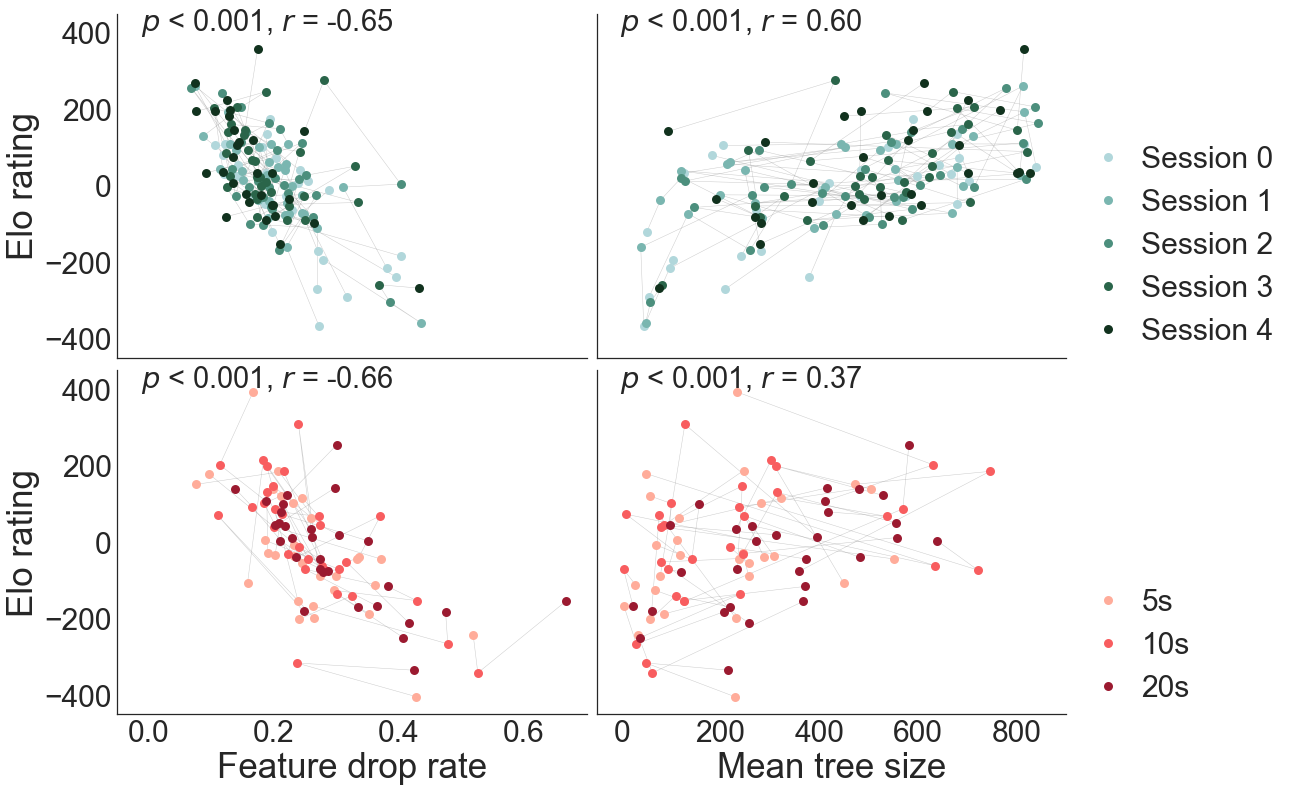

In [35]:
fig, axes = plt.subplots(2, 2, figsize=(15, 11), sharey=True)


divtypes = ['session', 'condition']
divlabels = ['Session {}', '{}s']
variables = ordict([('Feature Drop Rate', 'attention'), ('Tree Size', 'tree_size')])
legs = []

for e, experiment in enumerate([pl, pt]):
    for i, key in enumerate(variables.keys()):
        val = variables[key]
        ax = axes[e, i]
        div = divtypes[e]
        colors = [greens, reds][e]
        
        for j in experiment['subject'].unique():
            pdata = experiment.loc[experiment['subject']==j, :]
            ax.plot(pdata[val], pdata['elo'], **lineplotkws)
        
        for l, j in enumerate(experiment[div].unique()):
            pdata = experiment.loc[experiment[div]==j, :]
            c, la = colors[l], divlabels[e].format(j)
            ax.plot(pdata[val], pdata['elo'], color=c, label=la, **scatterkws)
            
        if i==1: 
            leg = ordict(zip(*ax.get_legend_handles_labels())).items()
            leg = ordict([(k, v) for k, v in leg if v != 'none'])
            leg = ax.legend(leg.keys(), leg.values(), loc=(1,0), handletextpad=0.1)
            legs.append(leg)
            
        res = stats.linregress(experiment[val], experiment['elo'])
        x = .05 if i == 0 else 20
        pvaltext = res.pvalue if res.pvalue > .0005 else .001
        textstring = r'$\it{{p}}$ < {:.3f}, $\it{{r}}$ = {:.2f}'.format(pvaltext, res.rvalue)
        ax.text(.05, .95, textstring, fontsize=29, transform=ax.transAxes)

plt.setp(
    axes[:, 0],
    ylabel='Elo rating', ylim=[-450, 450], yticks=np.arange(-400, 500, 200),
    xlim=[-.05, .7], xticks=np.arange(0, .8, .2)
)

plt.setp(axes[:, 1], xlim=[-50, 900], xticks=np.arange(0, 1050, 200))
plt.setp(axes[0, :], xticks=[])
axes[1, 0].set_xlabel('Feature drop rate')
axes[1, 1].set_xlabel('Mean tree size')

sns.despine()
plt.tight_layout()
fig.savefig(os.path.join(figdir, 'Elo vs Params.png'), bbox_extra_artists=legs, bbox_inches='tight')

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(13, 13), sharex=False, sharey=False)

scatterkws['markersize'] = 8
param1 = 'tree_size'
param2 = 'value_quality'

ax = axes[0, 0]
curve_like_plot('rt', 'learning', ax=ax, texton=True)
    
ax = axes[0, 1]
curve_like_plot('rt', 'timed', ax=ax, texton=True)

ax = axes[1, 0]
curve_like_plot(param2, 'learning', ax=ax, texton=True)
    
ax = axes[1, 1]
curve_like_plot(param2, 'timed', ax=ax, texton=True)

plt.setp(axes[0, :], ylim=[1, 6], xticks=[])
plt.setp(axes[1, :], ylim=[.5, .56])
plt.setp(axes[:, 1], yticks=[])
plt.setp(axes[0, 0], ylabel='Mean response time (s)')
plt.setp(axes[1, 0], ylabel='Value quality', xlabel='Session number', xticks=[0, 1, 2, 3, 4])
plt.setp(axes[1, 1], xlabel='Time limit (s)', xticks=[5, 10, 20])

plt.tight_layout()
sns.despine()
fig.savefig(os.path.join(figdir, 'vq and rt vs condition'))

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(13, 6), sharex=False, sharey=False, squeeze=False)

scatterkws['markersize'] = 8
param1 = 'tree_size'
param2 = 'value_quality'

ax = axes[0, 0]
curve_like_plot('rt', 'learning', ax=ax, texton=True)
    
ax = axes[0, 1]
curve_like_plot('rt', 'timed', ax=ax, texton=True)

plt.setp(axes[0, :], ylim=[1, 6], xticks=[])
plt.setp(axes[:, 1], yticks=[], xlabel='Time limit (s)', xticks=[5, 10, 20])
plt.setp(axes[0, 0], ylabel='Mean response time (s)', xlabel='Session number', xticks=[0, 1, 2, 3, 4])

plt.tight_layout()
sns.despine()
fig.savefig(os.path.join(figdir, 'rt vs condition'))

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(13, 13), sharex=True)
## REMIX WITH VALQUAL FIG
scatterkws['markersize'] = 9

ax = axes[0, 0]
scatter_plot('tree_size', 'rt', 'learning', ax=ax, reduce=True, texton=True)

ax = axes[0, 1]
scatter_plot('tree_size', 'rt', 'timed', ax=ax, reduce=True, texton=True)

ax = axes[1, 0]
scatter_plot(param1, param2, 'learning', ax=ax, texton=True, textloc='top', reduce=True)  

ax = axes[1, 1]
scatter_plot(param1, param2, 'timed', ax=ax, texton=True, textloc='top', reduce=True)

plt.setp(axes[0, :], ylim=[0, 13], yticks=np.arange(0, 13, 3))
plt.setp(axes[1, :], ylim=[0, 1], xticks=np.arange(0, 1000, 200), xlabel='Tree size')
plt.setp(axes[0, 0], ylabel='Mean response time (s)')
plt.setp(axes[1, 0], ylabel='Value quality')
plt.setp(axes[:, 1], yticks=[])

sns.despine()
plt.tight_layout()
fig.savefig(os.path.join(figdir, 'rt and vq vs tree size'))

/Users/gianni/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


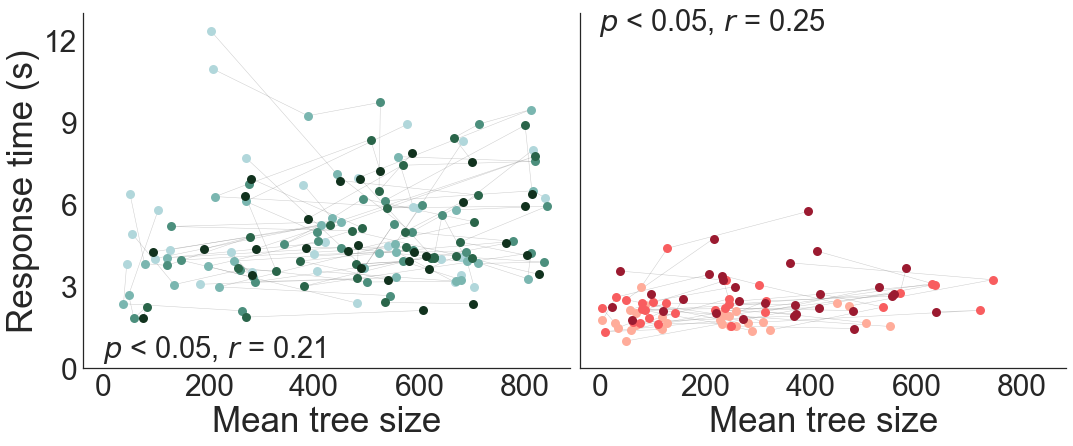

In [63]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6.2), sharex=True, squeeze=False)
scatterkws['markersize'] = 9

ax = axes[0, 0]
scatter_plot('tree_size', 'rt', 'learning', ax=ax, reduce=True, texton=True)

ax = axes[0, 1]
scatter_plot('tree_size', 'rt', 'timed', ax=ax, reduce=True, texton=True, textloc='top')

# ax = axes[1, 0]
# scatter_plot(param1, param2, 'learning', ax=ax, texton=True, reduce=True, textloc='top')  

# ax = axes[1, 1]
# scatter_plot(param1, param2, 'timed', ax=ax, texton=True, reduce=True, textloc='top')

plt.setp(axes[0, :], ylim=[0, 13], yticks=np.arange(0, 13, 3), xlabel='Mean tree size')
# plt.setp(axes[1, :], ylim=[0, 1], xticks=np.arange(0, 1000, 200), xlabel='Tree size')
plt.setp(axes[0, 0], ylabel='Response time (s)')
# plt.setp(axes[1, 0], ylabel='Value quality')
plt.setp(axes[:, 1], yticks=[])

sns.despine()
plt.tight_layout()
fig.savefig(os.path.join(figdir, 'rt vs tree size'))

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(13, 6), sharex=True, sharey=True)
param1 = 'tree_size'
param2 = 'attention'

ax = axes[0]
scatter_plot(param1, param2, 'learning', ax=ax, texton=True, reduce=True, textloc='top')

ax = axes[1]
scatter_plot(param1, param2, 'timed', ax=ax, texton=True, reduce=True, textloc='top')

plt.setp(axes, xlabel='Tree size')#, xticks=np.arange(0, 1000, 200))
plt.setp(axes[0], ylabel='Feature drop rate')#, ylim=[-.05, .9])

plt.tight_layout()
sns.despine()
fig.savefig(os.path.join(figdir, 'attn vs treesize.png'))

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(13, 6), sharey=True)
param1 = 'rt'
param2 = 'attention'

ax = axes[0]
scatter_plot(param1, param2, 'learning', ax=ax, reduce=True, texton=True, textloc='top')

ax = axes[1]
scatter_plot(param1, param2, 'timed', ax=ax, reduce=True, texton=True)

plt.tight_layout()
sns.despine()

/Users/gianni/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


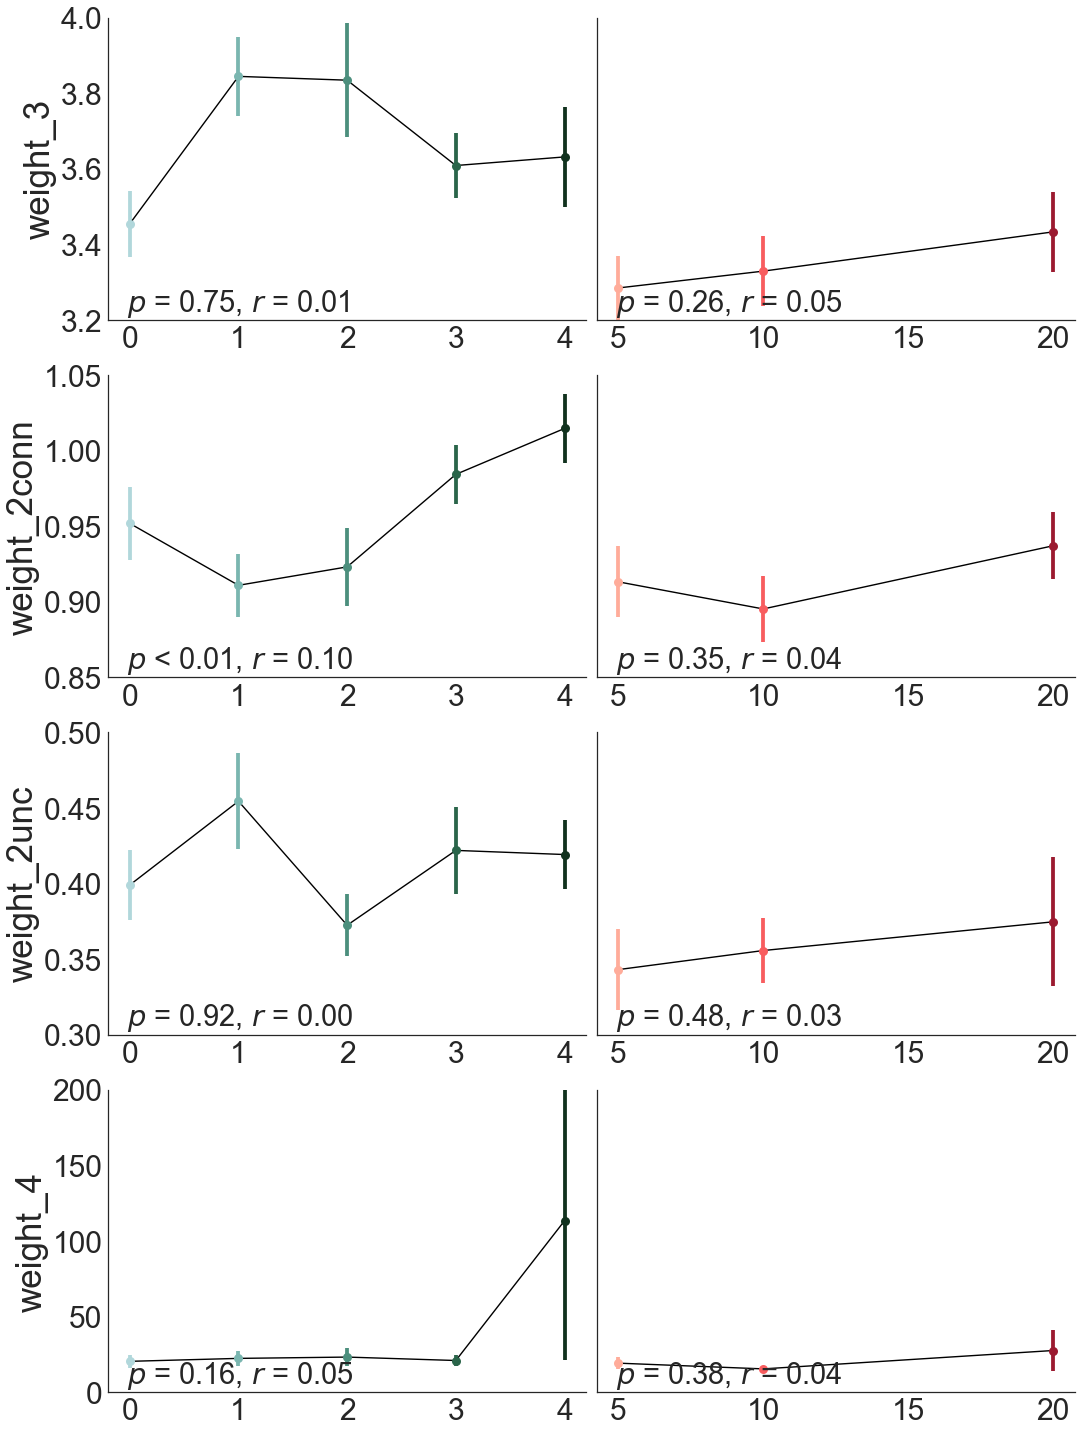

In [252]:
fig, axes = plt.subplots(4, 2, figsize=(15, 20))

for row, param in enumerate(['weight_3', 'weight_2conn', 'weight_2unc', 'weight_4']):
    ax = axes[row, 0]
    curve_like_plot(param, 'learning', ax=ax, texton=True)
    plt.setp(ax, ylabel=param)
    
    ax = axes[row, 1]
    curve_like_plot(param, 'timed', ax=ax, texton=True)
    
plt.setp(axes[0, :], ylim=[3.2, 4.0])
plt.setp(axes[1, :], ylim=[.85, 1.05])
plt.setp(axes[2, :], ylim=[.3, .5])
plt.setp(axes[3, :], ylim=[0, 200])

plt.setp(axes[:, 1], yticks=[])
sns.despine()
plt.tight_layout()

/Users/gianni/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


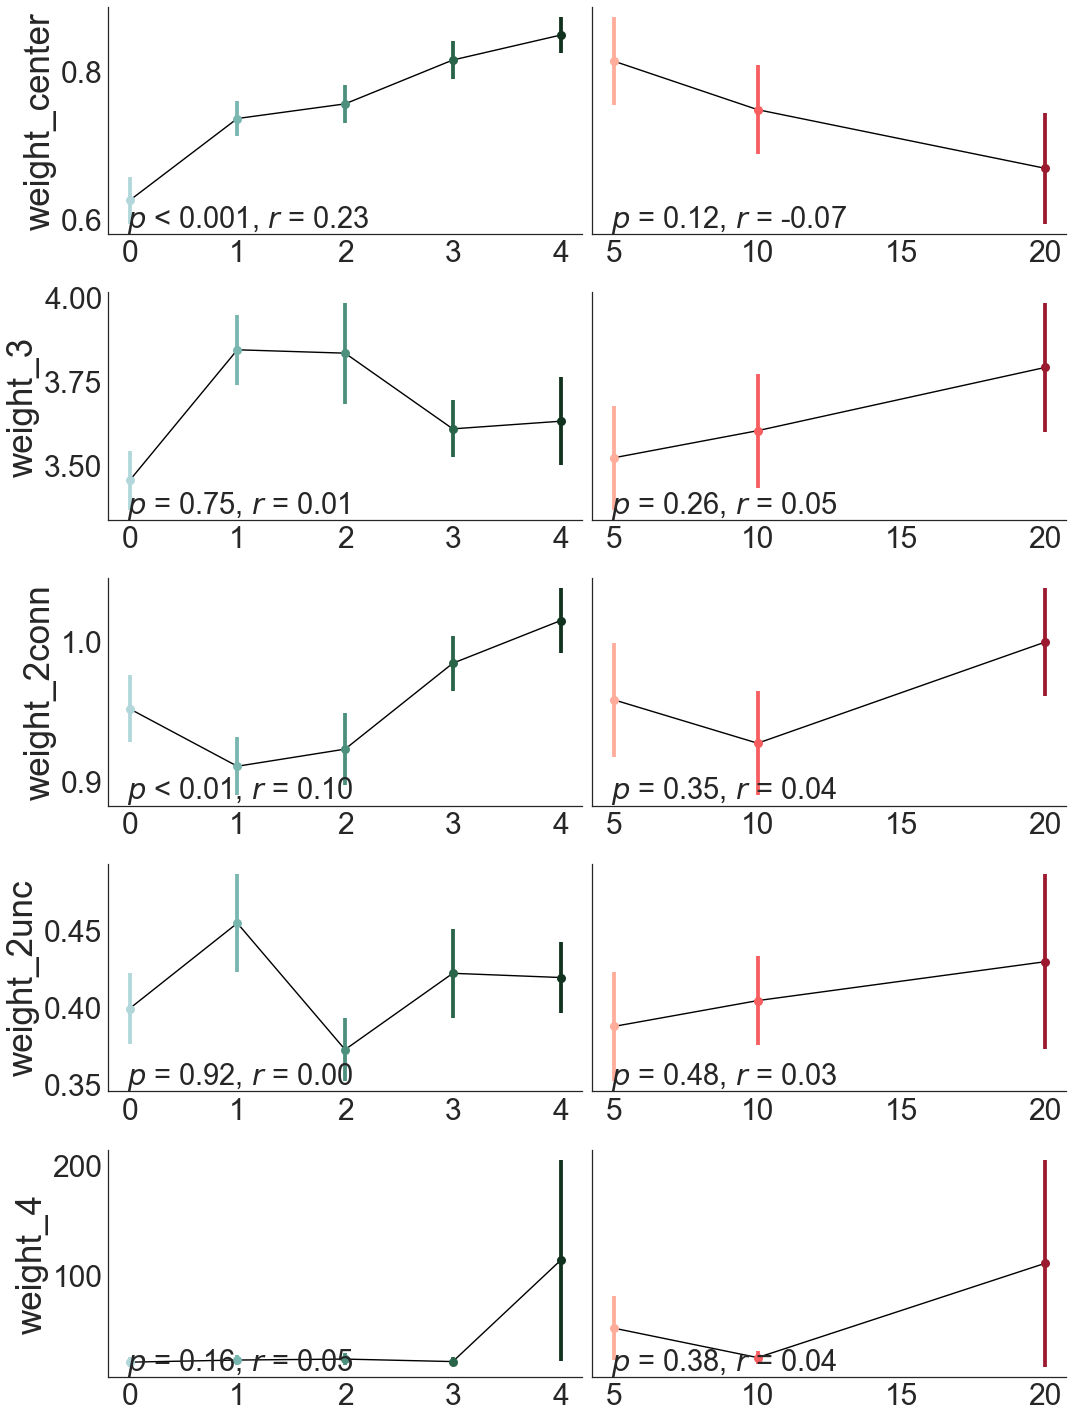

In [332]:
fig, axes = plt.subplots(5, 2, figsize=(15, 20))

for row, param in enumerate(['weight_center', 'weight_3', 'weight_2conn', 'weight_2unc', 'weight_4']):
    ax = axes[row, 0]
    curve_like_plot(param, 'learning', ax=ax, texton=True)
    plt.setp(ax, ylabel=param)
    
    ax = axes[row, 1]
    curve_like_plot(param, 'timed', ax=ax, texton=True)
    
# plt.setp(axes[0, :], ylim=[3.2, 4.0])
# plt.setp(axes[1, :], ylim=[.85, 1.05])
# plt.setp(axes[2, :], ylim=[.3, .5])
# plt.setp(axes[3, :], ylim=[0, 200])

plt.setp(axes[:, 1], yticks=[])
sns.despine()
plt.tight_layout()

-0.0808538838626
-0.0693924025623
0.0518571387122
0.0241820758495
0.0731878277696
-0.0827625581602
-4.93822888773e-05
-0.00468160065811
-1.69414801829e-06


/Users/gianni/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


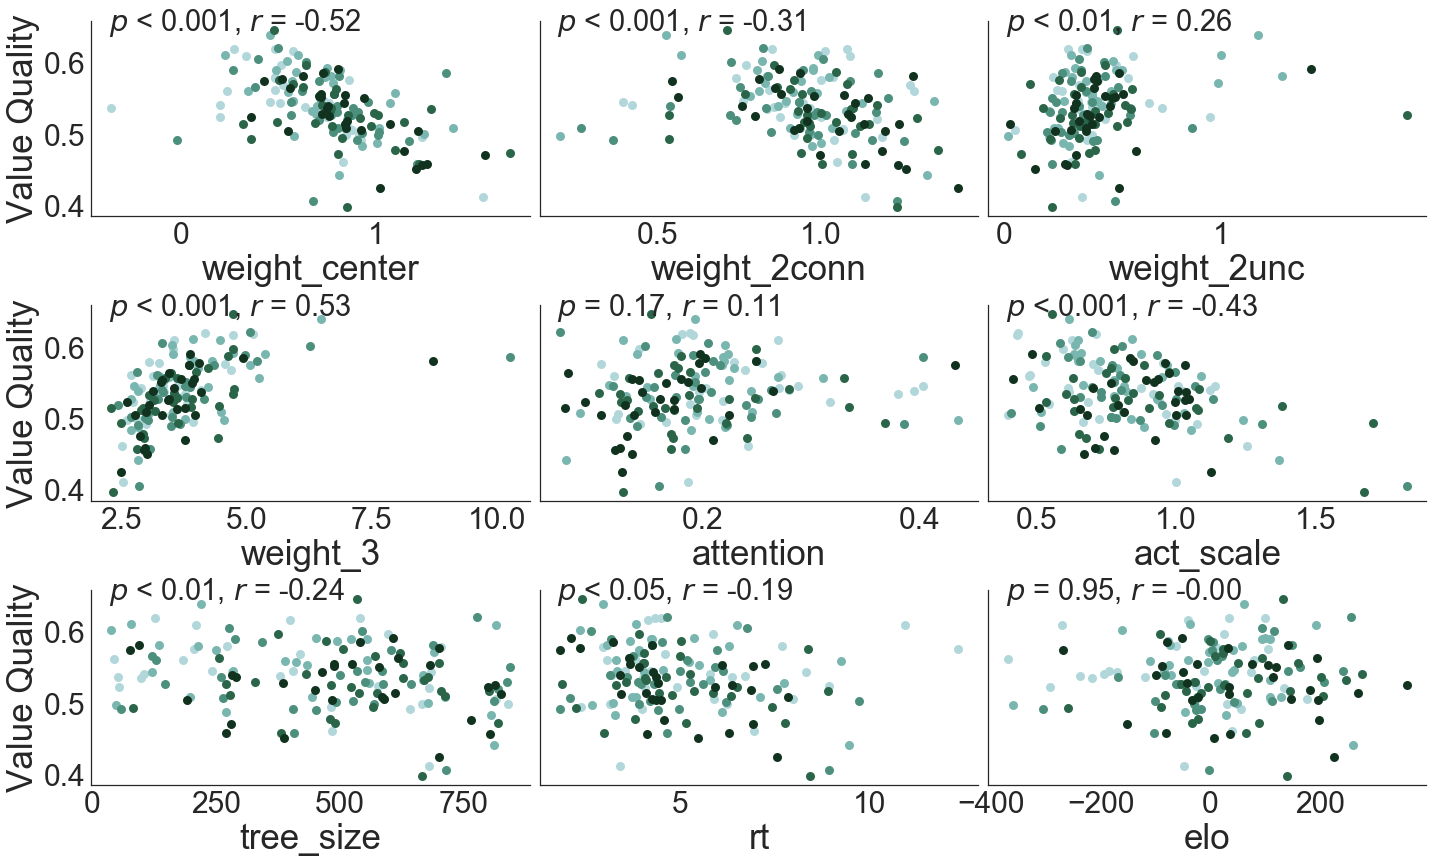

In [334]:
fig, axes = plt.subplots(3, 3, figsize=(20, 12), sharey=True)
for j, w in enumerate(['mc weight_center', 'mc weight_2conn', 'mc weight_2unc', 
                       'mc weight_3', 'mc attention', 'mc act_scale',
                       'mc tree_size', 'mc rt', 'mc elo']):
    ax = axes.flatten()[j]
#     scatter_plot(w[3:], 'value_quality', 'timed', ax=ax, texton=True, lineon=False, reduce=True)
    scatter_plot(w[3:], 'value_quality', 'learning', ax=ax, texton=True, textloc='top', reduce=True, lineon=False, printslope=True)
    plt.setp(ax, xlabel=w[3:])
    
plt.setp(axes[:, 0], ylabel='Value Quality')
plt.tight_layout()
sns.despine()

/Users/gianni/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


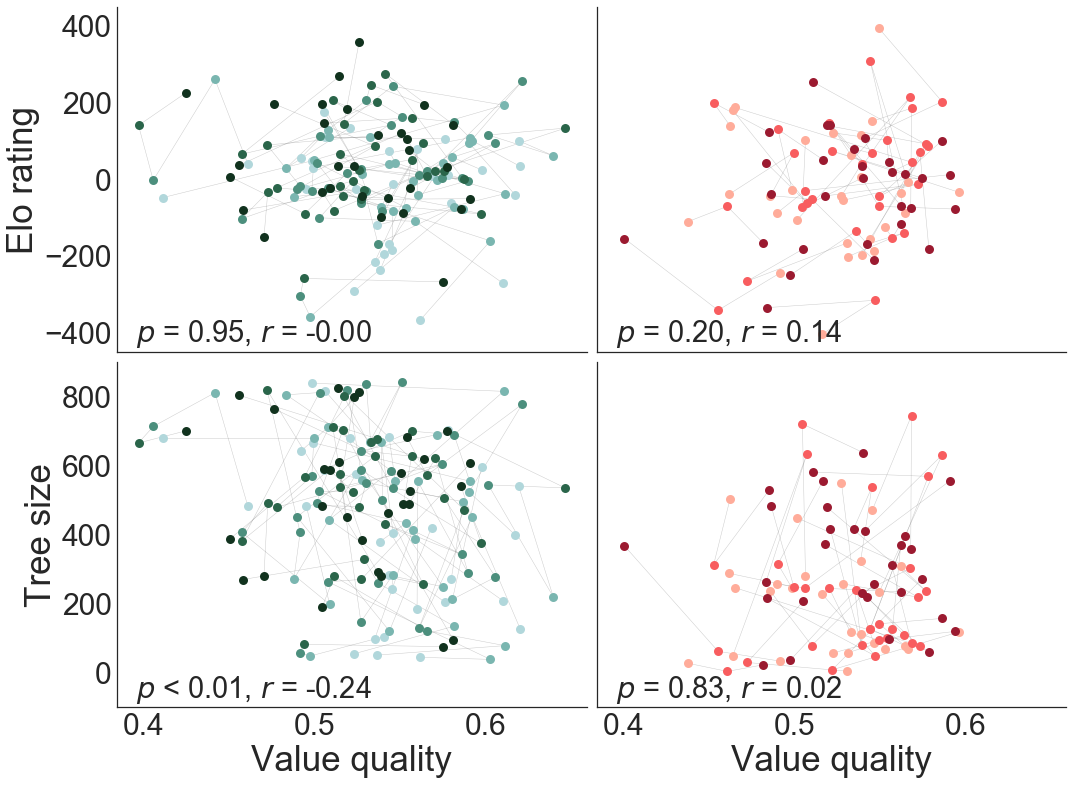

In [51]:
fig, axes = plt.subplots(2, 2, figsize=(15, 11), sharex=True)
ax = axes[0, 0]
scatter_plot('value_quality', 'elo', 'learning', ax=ax, texton=True, reduce=True)

ax = axes[0, 1]
scatter_plot('value_quality', 'elo', 'timed', ax=ax, texton=True, reduce=True)

ax = axes[1, 0]
scatter_plot('value_quality', 'tree_size', 'learning', ax=ax, texton=True, reduce=True)

ax = axes[1, 1]
scatter_plot('value_quality', 'tree_size', 'timed', ax=ax, texton=True, reduce=True)


plt.setp(axes[0, :], ylim=[-450, 450])
plt.setp(axes[0, 0], ylabel='Elo rating')
plt.setp(axes[0, 1], yticks=[])

plt.setp(axes[1, :], ylim=[-100, 900], xlabel='Value quality')
plt.setp(axes[1, 0], ylabel='Tree size')
plt.setp(axes[1, 1], yticks=[])
plt.tight_layout()
sns.despine()

/Users/gianni/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


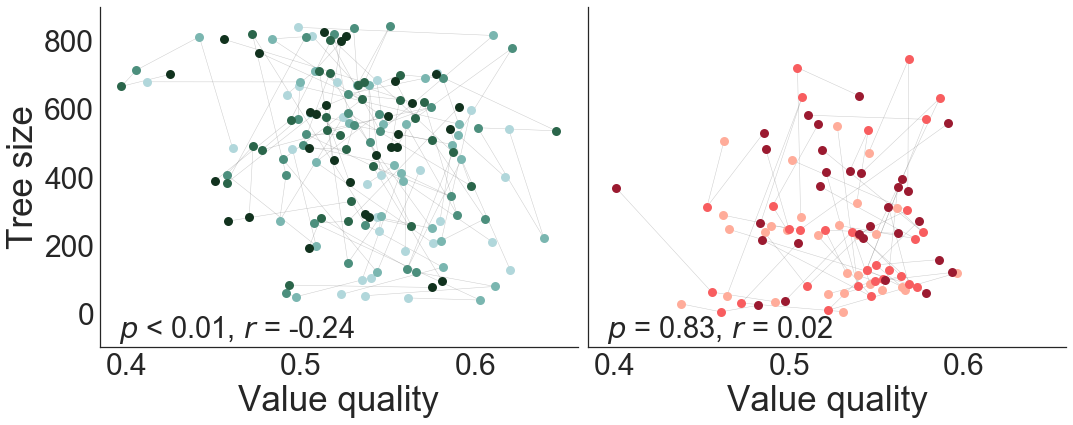

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharex=True, squeeze=False)

ax = axes[0, 0]
scatter_plot('value_quality', 'tree_size', 'learning', ax=ax, texton=True, reduce=True)

ax = axes[0, 1]
scatter_plot('value_quality', 'tree_size', 'timed', ax=ax, texton=True, reduce=True)

plt.setp(axes[0, :], ylim=[-100, 900], xlabel='Value quality')
plt.setp(axes[0, 0], ylabel='Tree size')
plt.setp(axes[0, 1], yticks=[])
plt.tight_layout()
sns.despine()

fig.savefig(os.path.join(figdir, 'vq vs ts.png'))

/Users/gianni/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


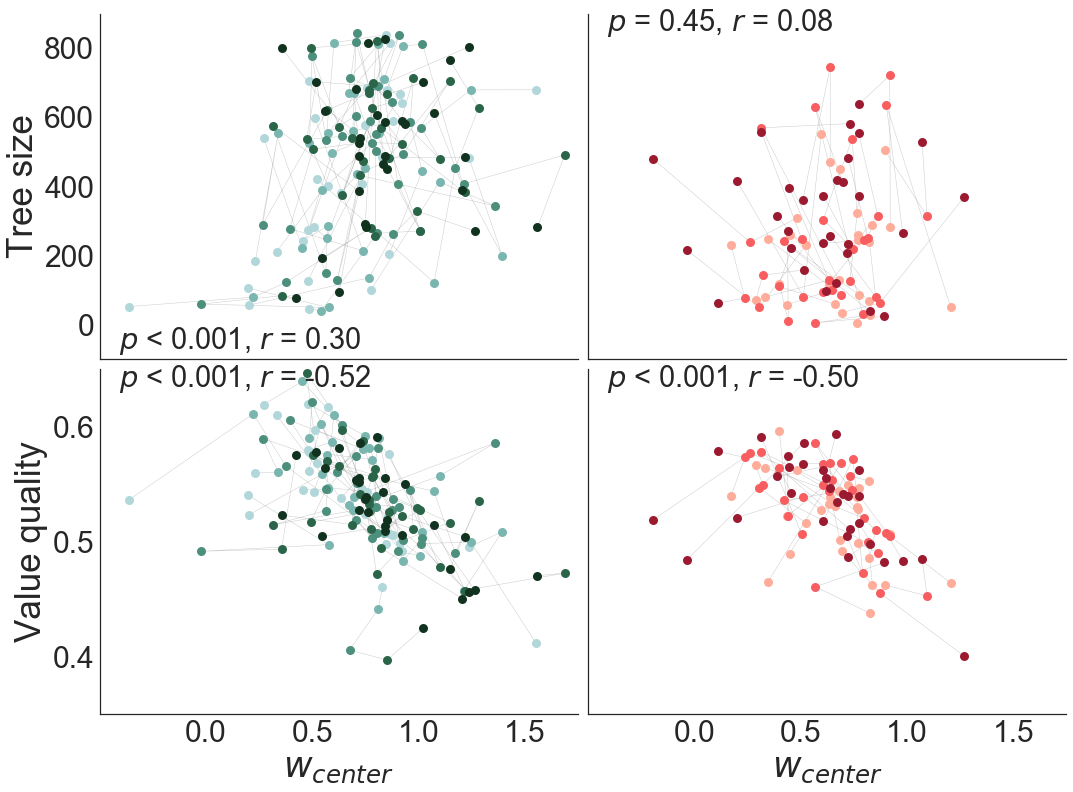

In [50]:
fig, axes = plt.subplots(2, 2, figsize=(15, 11), sharex=True)

for row, param in enumerate(['tree_size', 'value_quality']):

    ax = axes[row, 0]
    tl = 'top' if row in [1] else 'bottom'
    scatter_plot('weight_center', param, 'learning', ax=ax, texton=True, reduce=True, textloc=tl)

    ax = axes[row, 1]
    tl = 'top' if row in [0, 1] else 'bottom'
    scatter_plot('weight_center', param, 'timed', ax=ax, texton=True, reduce=True, textloc='top')

plt.setp(axes[0, :], ylim=[-100, 900])
plt.setp(axes[0, 0], ylabel='Tree size')
plt.setp(axes[0, 1], yticks=[])

plt.setp(axes[1, :], ylim=[.35, .65], xlim=[-.5, 1.75], xticks=np.arange(0, 1.75, .5), xlabel=r'$\it{w}_{\it{center}}$')
plt.setp(axes[1, 0], ylabel='Value quality')
plt.setp(axes[1, 1], yticks=[])


plt.tight_layout()
sns.despine()
fig.savefig(os.path.join(figdir, 'w_center vs props.png'))

/Users/gianni/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


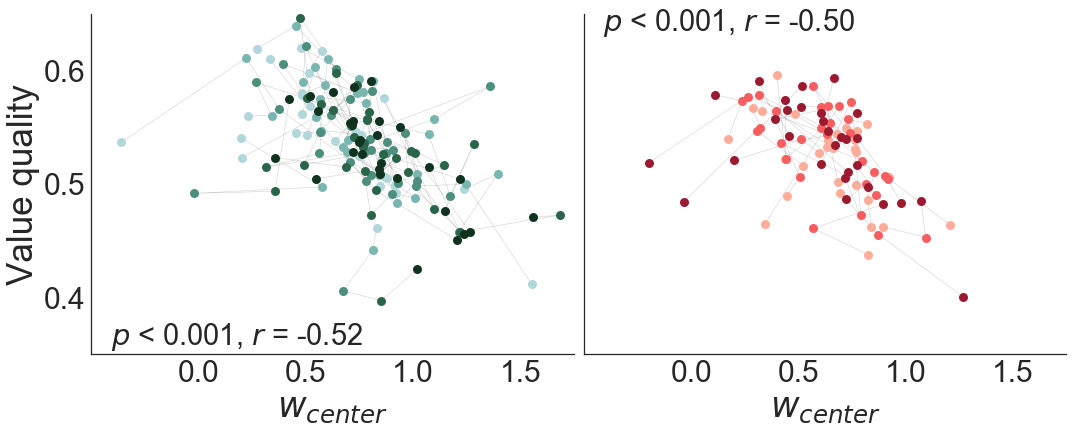

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharex=True, squeeze=False)

for row, param in enumerate(['value_quality']):

    ax = axes[row, 0]
    tl = 'top' if row in [1] else 'bottom'
    scatter_plot('weight_center', param, 'learning', ax=ax, texton=True, reduce=True, textloc=tl)

    ax = axes[row, 1]
    tl = 'top' if row in [0, 1] else 'bottom'
    scatter_plot('weight_center', param, 'timed', ax=ax, texton=True, reduce=True, textloc='top')

plt.setp(axes[0, :], ylim=[.35, .65], xlim=[-.5, 1.75], xticks=np.arange(0, 1.75, .5), xlabel=r'$\it{w}_{\it{center}}$')
plt.setp(axes[0, 0], ylabel='Value quality')
plt.setp(axes[0, 1], yticks=[])

plt.tight_layout()
sns.despine()
fig.savefig(os.path.join(figdir, 'w_center vs vq.png'))

/Users/gianni/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


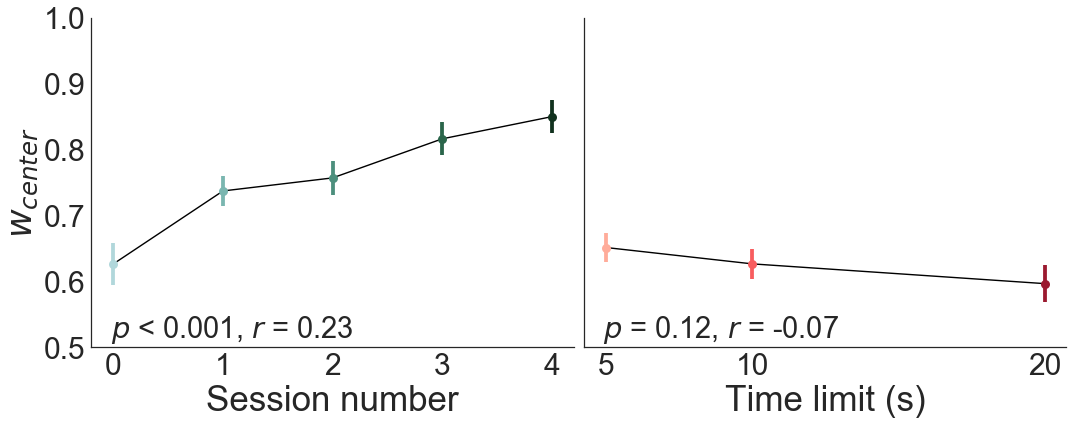

In [285]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
ax = axes[0]
curve_like_plot('weight_center', 'learning', ax=ax, texton=True)
ax = axes[1]
curve_like_plot('weight_center', 'timed', ax=ax, texton=True)
plt.setp(axes[0], ylabel=r'$\it{w}_{\it{center}}$', xlabel='Session number')
plt.setp(axes[1], xlabel='Time limit (s)', xticks=[5, 10, 20], ylim=[.5, 1])

plt.tight_layout()
sns.despine()

/Users/gianni/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


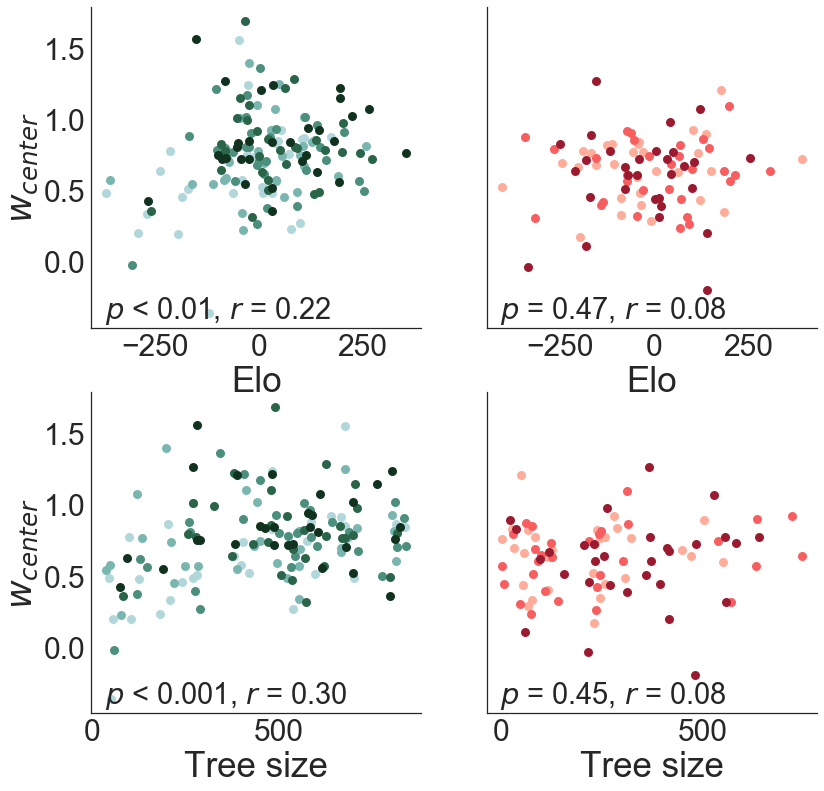

In [213]:
fig, axes = plt.subplots(2, 2, figsize=(13, 13), sharey=True)

scatter_plot('elo', 'weight_center', 'learning', ax=axes[0, 0], texton=True, lineon=False, reduce=True)
scatter_plot('elo', 'weight_center', 'timed', ax=axes[0, 1], texton=True, lineon=False, reduce=True)

scatter_plot('tree_size', 'weight_center', 'learning', ax=axes[1, 0], texton=True, lineon=False, reduce=True)
scatter_plot('tree_size', 'weight_center', 'timed', ax=axes[1, 1], texton=True, lineon=False, reduce=True)

plt.setp(axes[0, :], xlabel='Elo')
plt.setp(axes[:, 0], ylabel=r'$\it{w}_{\it{center}}$')
plt.setp(axes[1, :], xlabel='Tree size')
sns.despine()

In [325]:
params_lrn.columns

Index(['subject', 'session', 'group', 'elo', 'prune_thresh', 'gamma',
       'attention', 'lapse', 'act_scale', 'weight_center', 'weight_2conn',
       'weight_2unc', 'weight_3', 'weight_4', 'tree_size', 'value_quality',
       'mean_elo', 'rt', 'mc elo', 'mc tree_size', 'mc attention', 'mc rt',
       'mc lapse', 'mc act_scale', 'mc prune_thresh', 'mc value_quality',
       'mc weight_center', 'mc weight_2conn', 'mc weight_2unc', 'mc weight_3',
       'mc weight_4'],
      dtype='object')

## Model comparison

In [322]:
model_comp_file = os.path.expanduser('/Users/gianni/Downloads/loglik_hvh_all_models.txt')
model_comp_data = pd.read_csv(model_comp_file, sep=r'\s+', names=['nll', 'sem', 'name'])
keep = {
    'final': 'Heuristic search',
    'final_nodelta': 'No feature dropping',
    'final_notree': 'No tree search',
    'final_no3': r'No $\it{f}_{\mathrm{2}}$',
    'final_nocenter': r'No $\it{f}_{\mathrm{center}}$',
    'final_fixed_depth': 'Fixed search depth'
    'final_optweights'
}
model_comp_data = model_comp_data.loc[model_com]

,nll,sem,name
0,1.99750,0.000000,final
1,2.11670,0.020226,final_nonoise
2,2.04850,0.010422,final_nodelta
3,2.03470,0.011808,final_noprune
4,2.02100,0.017310,final_notree
5,2.00390,0.008807,final_noact
6,2.24540,0.017970,final_no3
7,2.06910,0.015489,final_no2conn
8,2.05650,0.015373,final_nocenter
9,2.01890,0.010967,final_no2unc


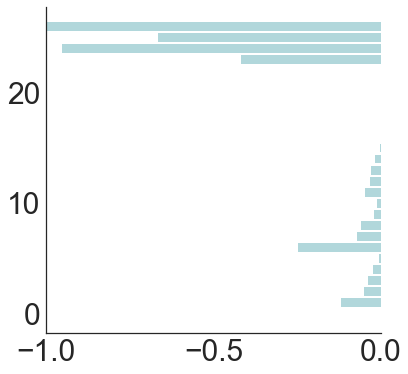

In [324]:
fig, axes = plt.subplots(1, 1, figsize=(6, 6))
y = model_comp_data['nll'] - model_comp_data.ix[0, 'nll']
axes.barh(y.index.values[::-1], -y[::-1])
plt.setp(axes, xlim=[-1, 0])
sns.despine()

# Parameters Learning

In [7]:
L = pd.read_csv(os.path.join(gdpath, 'Data/3_lrn/Clean/_summaries/all_games_all_fields.csv'))
A = pd.read_csv(os.path.join(gdpath, 'Data/3_lrn/Clean/_summaries/all_afc2s_all_fields.csv'))

A['correct'] = 1
A.loc[(A.aval > A.bval) & (A.response == A.b), 'correct'] = 0
A.loc[(A.bval > A.aval) & (A.response == A.a), 'correct'] = 0
T = A.loc[A.aval != A.bval, :]

ranks = pd.read_csv(os.path.join(gdpath, 'Analysis/3_lrn/ratings_learn.csv'))
R = ranks.loc[ranks['Subject'] >= 0, :]
for s in R.Subject.unique():
    _r = R.loc[R.Subject == s, :]
    _g = _r.sort_values('Session').games.cumsum()
    
    R.loc[_g.index, 'games td'] = _g.values
R = R.sort_values(['Subject', 'Session'])

for s in R.Subject.unique():
    for ss in R.Session.unique():
        R.loc[(R.Subject==s)&(R.Session==ss), 'mean rt'] = L.loc[(L.subject==s)&(L.session==ss), 'rt'].mean()
        if ss%2 == 0:
            R.loc[(R.Subject==s)&(R.Session==ss), 'afc score'] = T.loc[(T.subject==s)&(T.session==ss), 'correct'].mean()

ratings = pd.read_csv(os.path.join(gdpath, 'Analysis/5_tai/ratings_tai (6).csv'))
ratings['Subject'] = ratings['Name'].map(lambda x: int(x[3:5]) if len(x) == 11 else np.nan)
ratings['condition'] = ratings['Name'].map(lambda x: int(x[-2:]) if len(x) == 11 else np.nan)
ratings = ratings.sort_values(['Subject', 'condition'])

/Users/gianni/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


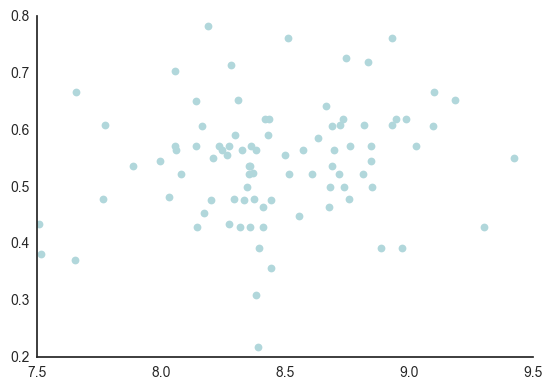

In [29]:
plt.plot(np.log(R['mean rt']), R['afc score'], linestyle='none', marker='o')
sns.despine()